In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm

from shamans.utils import eval_utils as eval

In [17]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False)
    return combined_csv

In [18]:
# load data
exp_id = 1
path_to_results = Path('results_2025-03-13/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])

print(exp_df['loc_algo'].unique())

['alp' 'mus' 'srp']


In [19]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)



In [20]:
# n_sources_choice = [1]
# source_type_choices = ['speech']
# snr_choices = np.arange(-30, 31, 10).tolist()
# noise_type_choices = ['awgn', 'alpha-1.2', 'alpha-0.8']
# sound_duration_choices = [0.5]
# add_reverb_choices = [False]

print(exp_df['sv_model'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())

['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
['awgn' 'alpha-0.8']
[1]
[-15 -12  -9  -6  -3   0   3   6   9  12  15  18  21]
[0.1 1. ]
[0.    0.123 0.273]
['alpha-1.2_beta-2_eps-1E-3_iter-500' 'alpha-1.2_beta-1_eps-1E-3_iter-500'
 'alpha-1.2_beta-0_eps-1E-3_iter-500' 'music_s-1' 'srp_phat']


## which seed is better for GP?

In [21]:
exp_df[
    exp_df['sv_model'].isin(['gp-steerer_8', 'gp-steerer_16', 'gp-steerer_32', 'gp-steerer_64', 'gp-steerer_128'])
].pivot_table(
    index=['seed'], 
    columns=['nObs'],
    values='ang_error', 
    aggfunc=['mean', 'std']
).style.format("{:.2f}").background_gradient(cmap='viridis', axis=0)

In [22]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666   
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

# SNR vs METHOD per RT60

Brute force plot

In [23]:
# noise_types = exp_df['noise_type'].unique()
# print(noise_types)

# for duration in [1]:
#     for noise_type in noise_types:
#         for rt60 in exp_df['rt60'].unique():
        
#             print(f"noise_type: {noise_type}, duration: {duration}, rt60: {rt60}")
        
#             df_ = exp_df[
#                 (exp_df['noise_type'] == noise_type)
#                 & (exp_df['snr'] >= -20)
#                 & (exp_df['sv_model'].isin(['ref', 'alg', 'gp-steerer_32']))
#                 & (exp_df['seed'] == best_seed)
#                 & (exp_df['rt60'] == rt60)
#                 & (exp_df['duration'] == duration)
#             ]

#             plt.figure(figsize=(10, 5))
#             ax = sns.relplot(
#                 x='snr', y='ang_error', hue='loc_method', 
#                 style='loc_algo',
#                 data=df_, kind='line', col='sv_model',)
#             ax.set(ylim=(0, 20))
#             plt.show()

Nice plots

In [24]:
nice_plot_df = exp_df[
    # (exp_df['noise_type'] == '')
    # (exp_df['noise_type'] == 'alpha-0.8')
    (exp_df['snr'] >= -20)
    & (exp_df['sv_model'].isin(['ref', 'alg', 'gp-steerer_32']))
    & (exp_df['loc_method'].isin(['srp_phat', 'music_s-1', 'alpha-1.2_beta-1_eps-1E-3_iter-500']))
    & (exp_df['seed'] == best_seed)
    & (exp_df['rt60'] > -1)
    & (exp_df['duration'] == 1.)
]

# rename loc_methods and sv_models
nice_plot_df.loc[nice_plot_df['loc_method'] == 'srp_phat', 'loc_method'] = 'SRP-PHAT'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'music_s-1', 'loc_method'] = 'MUSIC-1'
# nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'ALPHA-1.2_BETA-1'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'SHAMaNS'

nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'sv_model'] = 'Ref.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'sv_model'] = 'Alg.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'gp-steerer_32', 'sv_model'] = 'NS-32'


print(nice_plot_df['loc_method'].unique())
print(nice_plot_df['sv_model'].unique())

algo_order = ['SRP-PHAT', 'MUSIC-1', 'ALPHA-1.2_BETA-1']
algo_order = ['SRP-PHAT', 'MUSIC-1', 'SHAMaNS']
n_algos = len(algo_order)


['SHAMaNS' 'MUSIC-1' 'SRP-PHAT']
['Ref.' 'Alg.' 'NS-32']


In [25]:
perf = pd.pivot_table(nice_plot_df, values='ang_error', index=['snr'], columns=['loc_method', 'rt60', 'sv_model'], aggfunc=np.mean)
perf

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/4131289036.py:1: FutureWarning: The provided callable <function mean at 0x10fb22790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  perf = pd.pivot_table(nice_plot_df, values='ang_error', index=['snr'], columns=['loc_method', 'rt60', 'sv_model'], aggfunc=np.mean)


loc_method MUSIC-1                                                 SHAMaNS  \
rt60         0.000             0.123             0.273               0.000   
sv_model      Alg. NS-32  Ref.  Alg. NS-32  Ref.  Alg. NS-32  Ref.    Alg.   
snr                                                                          
-15           11.4  24.3  10.2  11.4  23.4  14.1  18.0  33.6  26.1    48.6   
-12            9.9  15.3   9.0   9.6  15.0  10.2  12.3  29.1  24.0    41.1   
-9            11.7   1.2   0.3  10.8   2.1   0.9  11.4  21.3  23.7    25.5   
-6            11.7   1.2   0.0  11.4   1.5   0.3  10.5  17.4  13.2    29.4   
-3            12.3   1.2   0.0  12.3   1.2   0.3  10.5   3.3   6.6    29.7   
 0            12.3   0.9   0.0  12.0   1.5   0.3  10.5   3.3   3.3    32.1   
 3            12.0   0.9   0.0  11.7   1.5   0.0  11.1   3.0   2.7    25.5   
 6            11.7   0.6   0.0  11.7   1.5   0.0  10.8   2.4   2.7    25.2   
 9            11.4   0.6   0.0  11.4   1.2   0.0  10.5   2.1   1.2    25.5   
 12           11.4   0.6   0.0  11.4   0.9   0.0   9.3   1.8   1.2    25.8   
 15           11.4   0.6   0.0  11.4   0.6   0.0   9.0   1.8   1.2    19.5   
 18           10.8   0.6   0.0  11.4   0.6   0.0   9.0   1.8   1.2    19.5   
 21           10.8   0.6   0.0  11.4   0.6   0.0   9.0   1.8   1.2    12.6   

loc_method  ...       SRP-PHAT                                               
rt60        ... 0.273    0.000            0.123            0.273             
sv_model    ...  Ref.     Alg. NS-32 Ref.  Alg. NS-32 Ref.  Alg. NS-32 Ref.  
snr         ...                                                              
-15         ...  30.6     10.5   0.6  0.0   8.7   1.2  0.0  13.8   3.0  1.8  
-12         ...  19.8     10.5   0.6  0.0   8.4   0.9  0.0  11.7   2.4  1.5  
-9          ...  12.3      8.7   0.3  0.0   8.7   0.9  0.0   9.9   2.4  1.2  
-6          ...   9.6      9.0   0.3  0.0   8.7   0.6  0.0   9.3   1.5  0.9  
-3          ...   9.3      8.4   0.3  0.0   8.4   0.6  0.0   9.3   1.5  1.2  
 0          ...   1.5      8.4   0.3  0.0   8.4   0.6  0.0   9.0   1.5  1.2  
 3          ...   1.5      8.1   0.3  0.0   8.4   0.6  0.0   8.7   1.5  1.5  
 6          ...   1.5      8.1   0.6  0.0   8.1   0.9  0.0   8.7   1.2  1.2  
 9          ...   1.5      7.8   0.6  0.0   8.1   0.9  0.0   8.7   0.9  1.5  
 12         ...   1.5      7.8   0.9  0.0   7.2   0.9  0.0   8.7   0.9  0.9  
 15         ...   1.5      7.2   0.9  0.0   7.2   0.9  0.0   8.7   0.9  0.9  
 18         ...   1.2      7.2   0.9  0.0   7.2   1.2  0.0   8.7   1.2  0.9  
 21         ...   1.2      7.2   0.9  0.0   7.2   1.2  0.0   8.4   1.2  0.9  

[13 rows x 27 columns]

In [26]:
pd.pivot_table(nice_plot_df[nice_plot_df['snr'] > 0], 
               values='ang_error', 
               index=['loc_method'], 
               columns=['sv_model'], 
               aggfunc=[np.mean, np.std])

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/1128385715.py:1: FutureWarning: The provided callable <function mean at 0x10fb22790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(nice_plot_df[nice_plot_df['snr'] > 0],
/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/1128385715.py:1: FutureWarning: The provided callable <function std at 0x10fb228b0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  pd.pivot_table(nice_plot_df[nice_plot_df['snr'] > 0],


mean                            std                    
sv_model         Alg.     NS-32      Ref.       Alg.     NS-32      Ref.
loc_method                                                              
MUSIC-1     10.885714  1.242857  0.542857   7.128971  2.538124  2.531062
SHAMaNS     28.957143  1.371429  0.700000  39.659266  2.961188  1.928433
SRP-PHAT     7.971429  0.928571  0.371429   9.401119  2.172653  1.447619

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/4292196610.py:20: FutureWarning: The provided callable <function mean at 0x10fb22790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  perf = pd.pivot_table(


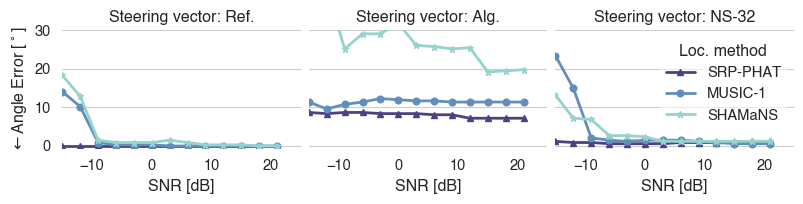

In [33]:
sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)

rt60s = nice_plot_df['rt60'].unique()
sv_models = nice_plot_df['sv_model'].unique()

fig, axarr = plt.subplots(1, len(sv_models),figsize=(8, 2), sharey=True, squeeze=False)

i= 0
rt60 = 0.123

perf = pd.pivot_table(
    nice_plot_df[nice_plot_df['rt60'] == rt60],
    values='ang_error', index=['snr'], columns=['loc_method', 'rt60', 'sv_model'], aggfunc=np.mean)

markers=['^','o','*','s','d','v'][:n_algos]

for j, sv_model in enumerate(sv_models):


    for alg,mkr in zip(algo_order, markers):
        axarr[i,j].plot(perf.index, perf[alg,rt60,sv_model], marker=mkr, clip_on=True)

    # remove the x-grid
    axarr[i,j].xaxis.grid(False)
    
    axarr[i,j].set_title(f'Steering vector: {sv_model}')

    # axarr[i,j].text(-0.1,1.5, 'A', fontsize=27, fontweight='bold')

    # nice legend box
    if j == 2:
        leg = axarr[i,j].legend(algo_order, title='Loc. method', frameon=True, framealpha=0.6)
        leg.get_frame().set_linewidth(0.0)
        # axarr[i,j].legend().set_visible(False)
    else:
        pass
        # axarr[i,j].legend().set_visible(False)

    # set all the labels
    axarr[i,j].set_xlabel('SNR [dB]')
    if j == 0:
        axarr[i,j].set_ylabel(r"$\leftarrow$" + 'Angle Error [$^\circ$]')
    else:
        axarr[i,j].set_ylabel('')
        
    axarr[i,j].set_xlim([-15,25])
    axarr[i,j].set_xticks([-10, 0, 10, 20])
    
    axarr[i,j].set_ylim([-0.5, 30])
    
    sns.despine(offset=10, trim=False, left=True, bottom=True, ax=axarr[i,j])
    
# add legend outside of the plot
# handles, labels = axarr[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=n_algos, frameon=True, framealpha=0.6)

# axarr[0,0].text(-25, 30, 'A', fontsize=27, fontweight='bold')

plt.tight_layout(pad=0.5)
plt.savefig('./eusipco2025_exp-1_snr-sweep_accuracy.pdf', bbox_inches='tight')

In [34]:
pd.pivot_table(
    nice_plot_df[nice_plot_df['snr'] > -10], 
    values='ang_error', 
    index=['loc_method','sv_model'], 
    columns=['snr',], 
    aggfunc=[np.mean, np.std]
)

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/2756156459.py:1: FutureWarning: The provided callable <function mean at 0x10fb22790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(
/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/2756156459.py:1: FutureWarning: The provided callable <function std at 0x10fb228b0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  pd.pivot_table(


mean                                                  \
snr                   -9    -6    -3     0     3     6     9     12    15   
loc_method sv_model                                                         
MUSIC-1    Alg.      11.3  11.2  11.7  11.6  11.6  11.4  11.1  10.7  10.6   
           NS-32      8.2   6.7   1.9   1.9   1.8   1.5   1.3   1.1   1.0   
           Ref.       8.3   4.5   2.3   1.2   0.9   0.9   0.4   0.4   0.4   
SHAMaNS    Alg.      34.8  36.8  33.9  36.8  31.1  31.0  31.0  31.1  26.9   
           NS-32      7.4   3.0   2.8   2.4   1.5   1.4   1.3   1.3   1.3   
           Ref.       5.0   3.9   3.8   1.2   1.2   1.0   0.7   0.6   0.6   
SRP-PHAT   Alg.       9.1   9.0   8.7   8.6   8.4   8.3   8.2   7.9   7.7   
           NS-32      1.2   0.8   0.8   0.8   0.8   0.9   0.8   0.9   0.9   
           Ref.       0.4   0.3   0.4   0.4   0.5   0.4   0.5   0.3   0.3   

                           ...        std                                   \
snr                    18  ...        -6         -3          0          3    
loc_method sv_model        ...                                               
MUSIC-1    Alg.      10.4  ...   6.939936   7.195337   7.061953   6.886981   
           NS-32      1.0  ...  25.505932   3.403388   3.403388   3.368850   
           Ref.       0.4  ...  18.669743   7.251651   4.249826   4.107455   
SHAMaNS    Alg.      26.9  ...  41.620073  39.038312  42.976067  41.722936   
           NS-32      1.4  ...   5.355181   5.351382   5.204952   3.600847   
           Ref.       0.4  ...  19.350207  19.354674   2.420254   2.420254   
SRP-PHAT   Alg.       7.7  ...   8.521160   8.797727   9.134030   9.255690   
           NS-32      1.1  ...   2.056820   2.056820   2.056820   2.056820   
           Ref.       0.3  ...   1.318705   1.509293   1.509293   1.672307   

                                                                            \
snr                         6          9          12         15         18   
loc_method sv_model                                                          
MUSIC-1    Alg.       7.133592   6.883289   7.251651   7.358150   7.316570   
           NS-32      2.620001   2.492701   2.341230   2.254938   2.254938   
           Ref.       4.107455   1.509293   1.509293   1.509293   1.509293   
SHAMaNS    Alg.      41.849610  41.966088  41.795994  38.163653  38.099646   
           NS-32      3.195336   2.941809   2.726518   2.726518   2.787381   
           Ref.       2.254938   1.942391   1.815190   1.815190   1.509293   
SRP-PHAT   Alg.       9.314286   9.371432   9.534416   9.636266   9.636266   
           NS-32      2.160508   2.056820   2.160508   2.160508   2.341230   
           Ref.       1.509293   1.672307   1.318705   1.318705   1.318705   

                                
snr                         21  
loc_method sv_model             
MUSIC-1    Alg.       7.316570  
           NS-32      2.254938  
           Ref.       1.509293  
SHAMaNS    Alg.      34.882515  
           NS-32      2.787381  
           Ref.       1.509293  
SRP-PHAT   Alg.       9.494334  
           NS-32      2.341230  
           Ref.       1.318705  

[9 rows x 22 columns]

In [39]:
sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)

rt60s = nice_plot_df['rt60'].unique()
sv_models = nice_plot_df['sv_model'].unique()


snr = 18

perf2 = pd.pivot_table(
    nice_plot_df[nice_plot_df["snr"] == snr ], 
    values='ang_error', index=['rt60'], 
    columns=['loc_method', 'sv_model'], aggfunc=np.mean)
perf2

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/2604428739.py:18: FutureWarning: The provided callable <function mean at 0x10fb22790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  perf2 = pd.pivot_table(


loc_method MUSIC-1            SHAMaNS            SRP-PHAT           
sv_model      Alg. NS-32 Ref.    Alg. NS-32 Ref.     Alg. NS-32 Ref.
rt60                                                                
0.000         10.8   0.6  0.0    19.5   0.9  0.0      7.2   0.9  0.0
0.123         11.4   0.6  0.0    19.5   1.2  0.0      7.2   1.2  0.0
0.273          9.0   1.8  1.2    41.7   2.1  1.2      8.7   1.2  0.9

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_39620/2612377532.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axarr[i,j].legend().set_visible(False)


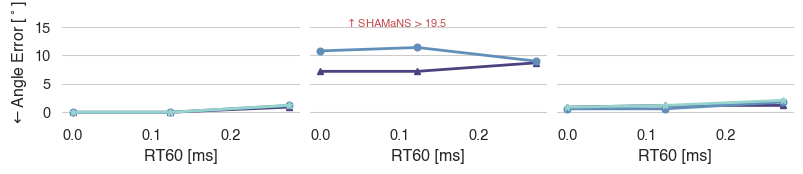

In [40]:
fig, axarr = plt.subplots(1, len(sv_models),figsize=(8, 1.7), sharey=True, squeeze=False)


for j, sv_model in enumerate(sv_models):

    markers=['^','o','*','s','d','v'][:n_algos]

    for alg,mkr in zip(algo_order, markers):
        axarr[i,j].plot(perf2.index, perf2[alg,sv_model], marker=mkr, clip_on=True)

    # remove the x-grid
    axarr[i,j].xaxis.grid(False)
    
    # axarr[i,j].set_title(f'{sv_model}')

    # ax.text(-45,87.5, 'A', fontsize=27, fontweight='bold')
    # nice legend box
    # if j == 2:
    #     leg = axarr[i,j].legend(algo_order, title='Algorithm', frameon=True, framealpha=0.6)
    #     leg.get_frame().set_linewidth(0.0)
    # else:
    axarr[i,j].legend().set_visible(False)

    # set all the labels
    axarr[i,j].set_xlabel('RT60 [ms]')
    if j == 0:
        axarr[i,j].set_ylabel(r"$\leftarrow$" + 'Angle Error [$^\circ$]')
    else:
        axarr[i,j].set_ylabel('')
    
    if j == 1:
        axarr[i,j].text(0.03, 15, r'$\uparrow$' + 'SHAMaNS > 19.5', color='r', fontsize=8)
    
    # axarr[i,j].set_xlim([-15,25])
    # axarr[i,j].set_xticks([-10, 0, 10, 20])
    
    axarr[i,j].set_ylim([-1, 18])
    plt.yticks([0, 5, 10, 15])
    
    sns.despine(offset=10, trim=False, left=True, bottom=True, ax=axarr[i,j])

# axarr[0,0].text(-0.085, 17, 'B', fontsize=27, fontweight='bold')

plt.tight_layout(pad=0.5)

plt.savefig('./eusipco2025_exp-1_rt60-sweep_accuracy.pdf', bbox_inches='tight')